# Sales forecast

In [50]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRFRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [52]:
store_sales = pd.read_csv("train.csv")

In [53]:
store_sales.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [54]:
# checking null values
store_sales.isna().sum()

date     0
store    0
item     0
sales    0
dtype: int64

no null values

In [55]:
# information like datatypes and null
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   store   913000 non-null  int64 
 2   item    913000 non-null  int64 
 3   sales   913000 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 27.9+ MB


In [56]:
#drop store and item
store_sales = store_sales.drop(['store','item'],axis = 1)

In [57]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   date    913000 non-null  object
 1   sales   913000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 13.9+ MB


In [17]:
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [32]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 913000 entries, 0 to 912999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype    
---  ------  --------------   -----    
 0   date    913000 non-null  period[M]
 1   sales   913000 non-null  int64    
dtypes: int64(1), period[M](1)
memory usage: 13.9 MB


In [20]:
store_sales.head(20)

,date,sales
0,2013-01-01,13
1,2013-01-02,11
2,2013-01-03,14
3,2013-01-04,13
4,2013-01-05,10
5,2013-01-06,12
6,2013-01-07,10
7,2013-01-08,9
8,2013-01-09,12
9,2013-01-10,9


In [61]:
# Assuming 'date' column is in string format, convert it to datetime format first
store_sales['date'] = pd.to_datetime(store_sales['date'])

In [62]:
# Convert 'date' column to a month period
store_sales['month'] = store_sales['date'].dt.to_period("M")

In [63]:
store_sales

,date,sales,month
0,2013-01-01,13,2013-01
1,2013-01-02,11,2013-01
2,2013-01-03,14,2013-01
3,2013-01-04,13,2013-01
4,2013-01-05,10,2013-01
...,...,...,...
912995,2017-12-27,63,2017-12
912996,2017-12-28,59,2017-12
912997,2017-12-29,74,2017-12
912998,2017-12-30,62,2017-12


In [64]:
# Group by the month period and sum the number of items in each month
monthly_sales = store_sales.groupby('month').sum().reset_index()

C:\Users\tanav\AppData\Local\Temp\ipykernel_26240\3816353064.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  monthly_sales = store_sales.groupby('month').sum().reset_index()


In [65]:
# Convert 'month' column to timestamp data type
monthly_sales['month'] = monthly_sales['month'].dt.to_timestamp()

Now 'monthly_sales' DataFrame contains the monthly sum of items, and 'month' column is in timestamp data type


In [66]:
monthly_sales.head(20)

,month,sales
0,2013-01-01,454904
1,2013-02-01,459417
2,2013-03-01,617382
3,2013-04-01,682274
4,2013-05-01,763242
5,2013-06-01,795597
6,2013-07-01,855922
7,2013-08-01,766761
8,2013-09-01,689907
9,2013-10-01,656587


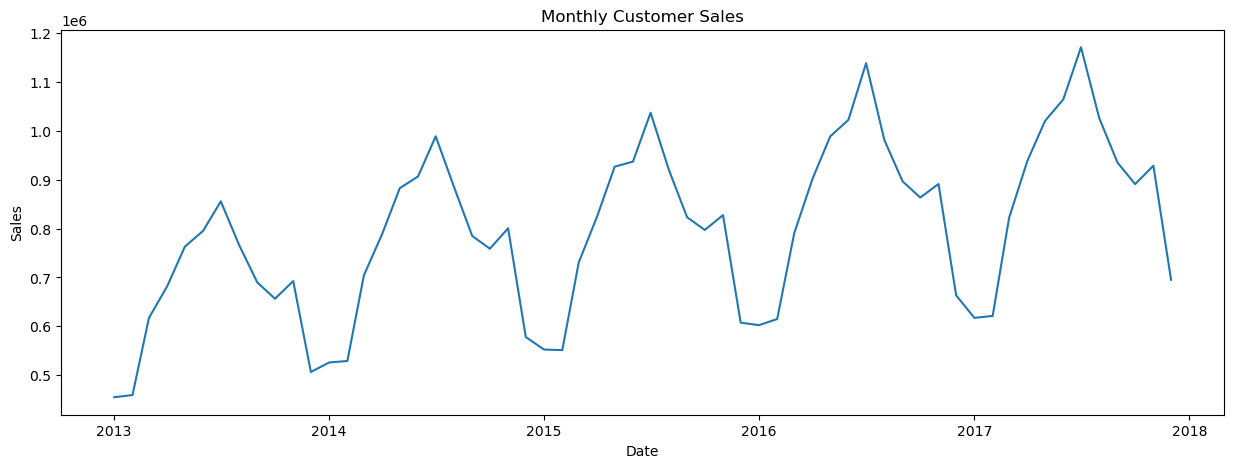

In [69]:
plt.figure(figsize= (15,5))
plt.plot(monthly_sales['month'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales')
plt.show()

In [70]:
monthly_sales['sales_diff'] = monthly_sales['sales'].diff()

In [71]:
monthly_sales.isna().sum()

month         0
sales         0
sales_diff    1
dtype: int64

In [72]:
monthly_sales = monthly_sales.dropna()

In [73]:
monthly_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59 entries, 1 to 59
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   month       59 non-null     datetime64[ns]
 1   sales       59 non-null     int64         
 2   sales_diff  59 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 1.8 KB


In [74]:
monthly_sales.head(20)

,month,sales,sales_diff
1,2013-02-01,459417,4513.0
2,2013-03-01,617382,157965.0
3,2013-04-01,682274,64892.0
4,2013-05-01,763242,80968.0
5,2013-06-01,795597,32355.0
6,2013-07-01,855922,60325.0
7,2013-08-01,766761,-89161.0
8,2013-09-01,689907,-76854.0
9,2013-10-01,656587,-33320.0
10,2013-11-01,692643,36056.0


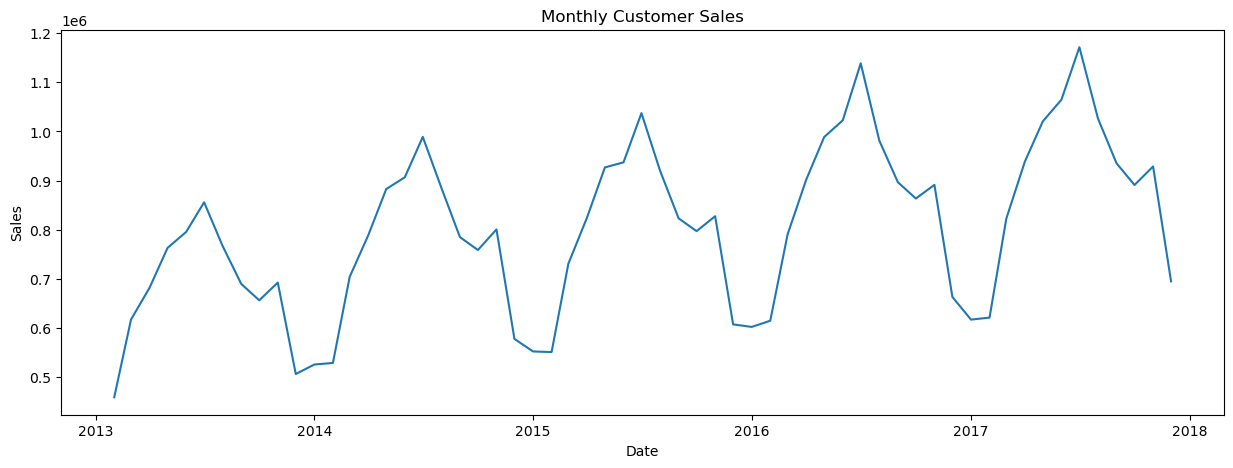

In [75]:
plt.figure(figsize= (15,5))
plt.plot(monthly_sales['month'], monthly_sales['sales'])
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Monthly Customer Sales')
plt.show()

### Dropping off sales and date

In [80]:
supervised_data = monthly_sales.drop(['month','sales'],axis = 1)

In [81]:
supervised_data

,sales_diff
1,4513.0
2,157965.0
3,64892.0
4,80968.0
5,32355.0
6,60325.0
7,-89161.0
8,-76854.0
9,-33320.0
10,36056.0


In [86]:
# preparing the supervised data
for i in range(1,13):
    col_name = 'month_' + str(i)
    supervised_data['col_name'] = supervised_data['sales_diff'].shift(i)
supervised_data = supervised_data.dropna().reset_index(drop = True)
supervised_data.head(10)

,sales_diff,col_name
0,-1196.0,3130.0
1,179634.0,175184.0
2,93516.0,84613.0
3,102435.0,93963.0
4,10282.0,23965.0
5,100166.0,82168.0
6,-116949.0,-103414.0
7,-97069.0,-100472.0
8,-26079.0,-26241.0
9,30392.0,41900.0
